In [82]:
#https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/

#https://github.com/flo7up/relataly-public-python-tutorials/blob/master/006%20Time%20Series%20Forecasting%20-%20Multi-Output%20Regression.ipynb

# Step #1 Load the Data

In [89]:
# Time Series Forecasting - Multi-output Regression for Stock Market Prediction
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
import time
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data

import tensorflow as tf
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
 
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.callbacks import EarlyStopping
# from keras.layers import Flatten,Dropout    
    
import seaborn as sns


# check the tensorflow version and the number of available GPUs
# print('Tensorflow Version: ' + tf.__version__)
# physical_devices = tf.config.list_physical_devices('GPU')
# print("Num GPUs:", len(physical_devices))



In [190]:
ab_path = "../data/SPY-Daily-Y09-Now.csv"
stockname='SPY'

start_date='2016-01-01'
end_date='2022-12-31'

date_col='Date'
prediction_col='EMA1'
# feature_cols=['Price','EMA1','MACD','RSI']
feature_cols=['EMA1']

split_way=2


#60 ->10
# Root MEAN Square Error(RMSE): 9.53
# Mean Absolute Error (MAE): 7.23
# Median Absolute Error (MAE): 7.23

#90->15
# Root MEAN Square Error(RMSE): 12.29
# Mean Absolute Error (MAE): 8.87
# Median Absolute Error (MAE): 8.87

#120-->20
# Root MEAN Square Error(RMSE): 18.15
# Mean Absolute Error (MAE): 14.43
# Median Absolute Error (MAE): 14.43

input_sequence_length =60
output_sequence_length =10
train_ratio=0.8

epochs = 100
batch_size = 32
n_early=15

main_obj_metric='mean_absolute_error'
option_obj_metric='mean_squared_error'
main_loss='mean_absolute_error'

# get from Tuned
n_input_neurons=120

In [191]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':date_col},inplace=True)
df.drop(columns=['Ticker'],inplace=True)
allCols=list(df.columns)
print(allCols)

['Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']


In [192]:
df[date_col]=df[date_col].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index(date_col,inplace=True)
df=df.loc[start_date:end_date,:]
df=df[feature_cols]
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2016-01-04 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    1762 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB
None


,EMA1
Date,
2022-12-23,386.73
2022-12-27,385.76
2022-12-28,384.11
2022-12-29,383.99
2022-12-30,383.70


# Step #2 Exploring the Data

In [193]:
ncols = 1
nrows = len(feature_cols)

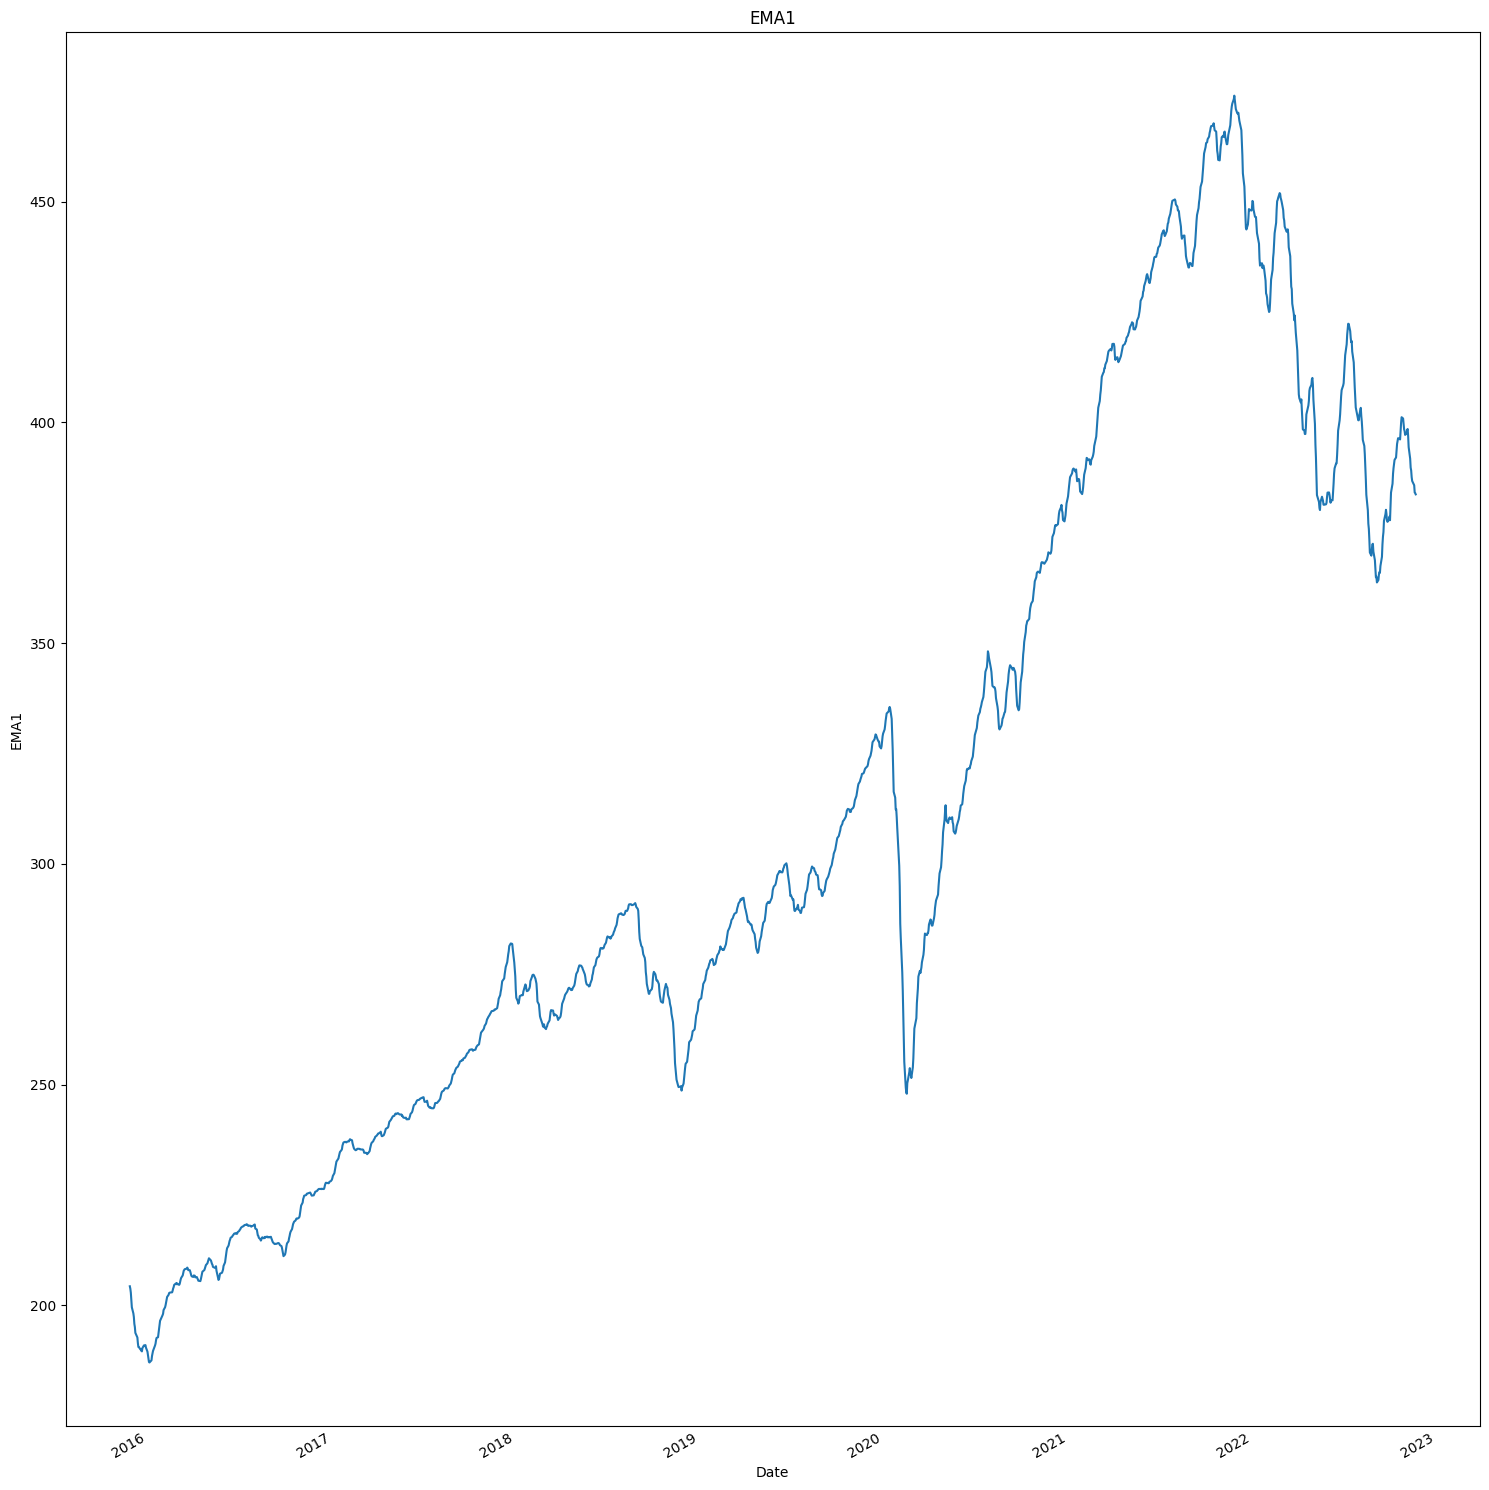

In [194]:


fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df.columns[i])
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [195]:
# Indexing Batches
df_train = df.sort_values(by=[date_col]).copy()
df_train.shape

(1762, 1)

In [196]:
def prepare_data(df):

    # List of considered Features
    FEATURES = feature_cols

    print(f'FEATURE LIST To Predict {prediction_col}')
    print([f for f in FEATURES])

    #Create the dataset with features and filter the data to the list of FEATURES"
    df_filter = df[FEATURES]
    
    print("Convert the data to numpy values")
    np_filter_unscaled = np.array(df_filter)
    np_filter_unscaled = np.reshape(np_filter_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)
    
    np_c_unscaled = np.array(df[prediction_col]).reshape(-1, 1)
    print(np_c_unscaled.shape)
    
    return np_filter_unscaled, np_c_unscaled

np_filter_unscaled, np_c_unscaled = prepare_data(df_train)   


print("Feature Data",np_filter_unscaled.shape)
print(np_filter_unscaled[:3])
print("Prediction Data",np_c_unscaled.shape)
print(np_c_unscaled[:3])

FEATURE LIST To Predict EMA1
['EMA1']
Convert the data to numpy values
(1762, 1)
(1762, 1)
Feature Data (1762, 1)
[[204.35]
 [203.81]
 [202.9 ]]
Prediction Data (1762, 1)
[[204.35]
 [203.81]
 [202.9 ]]


In [197]:
print(f"{input_sequence_length} = Set the input_sequence_length length - this is the timeframe used to make a multiple prediction")
print(f"{output_sequence_length} = The output sequence length is the number of steps that the neural network predicts")

#How much ratio to split
index_Close = df_train.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Close}")

# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_filter_unscaled.shape[0] * train_ratio)
print(f"{train_ratio} = {train_data_length} Split the training data into train and train data sets")

60 = Set the input_sequence_length length - this is the timeframe used to make a multiple prediction
10 = The output sequence length is the number of steps that the neural network predicts
Prediction Index = 0
0.8 = 1410 Split the training data into train and train data sets


In [198]:
print("Creating a separate scaler that works on a single column for scaling predictions")
print("Scale each feature to a range between 0 and 1")
scaler_train = MinMaxScaler()
print("Create a separate scaler for a single column")
scaler_pred = MinMaxScaler()


if split_way==1:
    print("Way#1 scale entire data and split data")   
    
    np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)
    
    print("All Data scaled for creating train and test data")    
    print(np_scaled.shape,np_scaled_c.shape)
    print(np_scaled_c[:5],np_scaled_c[:5])
    
    # Create the training and test data
    train_data =np_scaled[0:train_data_length, :]
    test_data = np_scaled[train_data_length - input_sequence_length:, :]

else:
    print("#Way#2 split data and apply  only train to scale")
    
    train_data = np_filter_unscaled[0:train_data_length, :]
    test_data = np_filter_unscaled[train_data_length - input_sequence_length:, :]

    np_PredictVal_unScaled=np_c_unscaled[0:train_data_length]
    
    print("Train Data to be scaled") 
    print(train_data.shape,np_PredictVal_unScaled.shape)
    print(train_data[:5],np_PredictVal_unScaled[:5])
    
    train_data=scaler_train.fit_transform(train_data)
    test_data=scaler_train.transform(test_data)
    
    print(f"For predict test that take the past {input_sequence_length} train value to predict the first test value")
    np_scaled=scaler_train.transform(np_filter_unscaled)
    np_scaled_c = scaler_pred.fit_transform(np_PredictVal_unScaled)
    
    print("Predict val data(Scaled from Train data")
    print(np_scaled_c.shape)
    print(np_scaled_c[:3])
print("=========================================")       
print("Scaled data completely")
print("train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:3])
print(test_data[:3])



Creating a separate scaler that works on a single column for scaling predictions
Scale each feature to a range between 0 and 1
Create a separate scaler for a single column
#Way#2 split data and apply  only train to scale
Train Data to be scaled
(1410, 1) (1410, 1)
[[204.35]
 [203.81]
 [202.9 ]
 [201.29]
 [199.59]] [[204.35]
 [203.81]
 [202.9 ]
 [201.29]
 [199.59]]
For predict test that take the past 60 train value to predict the first test value
Predict val data(Scaled from Train data
(1410, 1)
[[0.06823213]
 [0.06609741]
 [0.0625    ]]
Scaled data completely
train and test data
(1410, 1) (412, 1)
[[0.06823213]
 [0.06609741]
 [0.0625    ]]
[[0.89935168]
 [0.90002372]
 [0.89800759]]


In [199]:
print("The RNN needs data with the format of [samples, time steps, features]")
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation ,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

The RNN needs data with the format of [samples, time steps, features]


In [200]:
print(f"Here, we create {len(train_data)} samples, input_sequence_length time steps per sample, and f features")

print("Generate training data and test data")
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

print("The shapes: the result is: (rows, training_sequence, features) (prediction value, )")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



Here, we create 1410 samples, input_sequence_length time steps per sample, and f features
Generate training data and test data
The shapes: the result is: (rows, training_sequence, features) (prediction value, )
(1340, 60, 1) (1340, 10)
(342, 60, 1) (342, 10)


# Step #4 Model Training

In [201]:
# Configure the neural network model
print(f"Train Row : {x_train.shape[0]}")

tf.random.set_seed(7)

model = Sequential()
n_output_neurons = output_sequence_length
#n_input_neurons=100 # tuned on vpc
      
inputshape_Timestamps= x_train.shape[1]
no_feature=x_train.shape[2]

#n_input_neurons50
n_input_neurons =inputshape_Timestamps * no_feature
print(f"Model with n_neurons = inputshape Timestamps, each with feature variables {inputshape_Timestamps} x {no_feature} = {n_input_neurons} to predict {n_output_neurons}")

Train Row : 1340
Model with n_neurons = inputshape Timestamps, each with feature variables 60 x 1 = 60 to predict 10


In [202]:
n_input_neurons=120


model.add(LSTM(n_input_neurons, return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))
model.add(Dense(n_output_neurons))

# Compile the model
#model.compile(optimizer='adam', loss='mse')
model.compile(optimizer='adam',loss=main_loss,metrics=[main_obj_metric,option_obj_metric])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 120)               58560     
                                                                 
 dense_5 (Dense)             (None, 10)                1210      
                                                                 
Total params: 59,770
Trainable params: 59,770
Non-trainable params: 0
_________________________________________________________________


In [203]:

t_Start=time.time()
print(datetime.now())

if n_early==0:

 history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    shuffle=False,
                    validation_data=(x_test, y_test),
                    verbose=2
                   )
else:
    early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)
                    
    history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    shuffle=False,
                    validation_data=(x_test, y_test),
                    verbose=2,callbacks=[early_stop]
                   )
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

2023-01-19 01:24:29.807111
Epoch 1/100
42/42 - 9s - loss: 0.0508 - mean_absolute_error: 0.0508 - mean_squared_error: 0.0042 - val_loss: 0.0856 - val_mean_absolute_error: 0.0856 - val_mean_squared_error: 0.0116 - 9s/epoch - 208ms/step
Epoch 2/100
42/42 - 3s - loss: 0.0894 - mean_absolute_error: 0.0894 - mean_squared_error: 0.0124 - val_loss: 0.0616 - val_mean_absolute_error: 0.0616 - val_mean_squared_error: 0.0055 - 3s/epoch - 60ms/step
Epoch 3/100
42/42 - 2s - loss: 0.0492 - mean_absolute_error: 0.0492 - mean_squared_error: 0.0041 - val_loss: 0.0514 - val_mean_absolute_error: 0.0514 - val_mean_squared_error: 0.0041 - 2s/epoch - 59ms/step
Epoch 4/100
42/42 - 3s - loss: 0.0499 - mean_absolute_error: 0.0499 - mean_squared_error: 0.0040 - val_loss: 0.0653 - val_mean_absolute_error: 0.0653 - val_mean_squared_error: 0.0068 - 3s/epoch - 60ms/step
Epoch 5/100
42/42 - 2s - loss: 0.0444 - mean_absolute_error: 0.0444 - mean_squared_error: 0.0031 - val_loss: 0.0403 - val_mean_absolute_error: 0.040

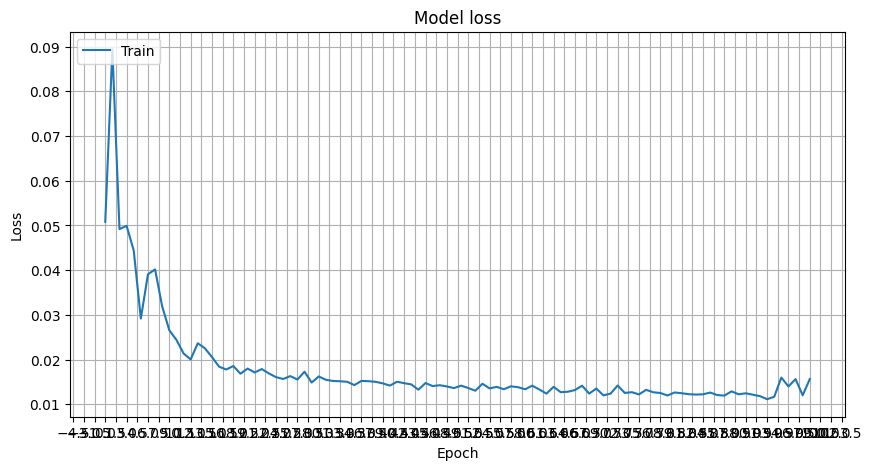

In [204]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

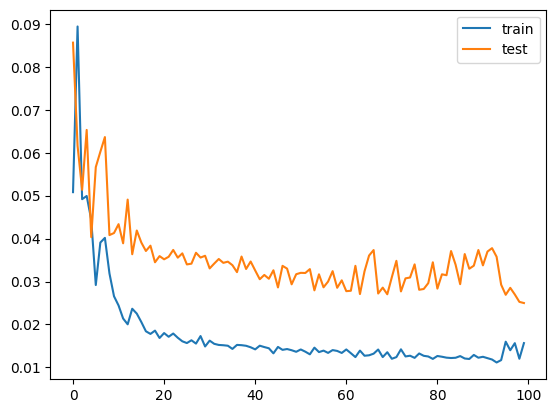

In [205]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

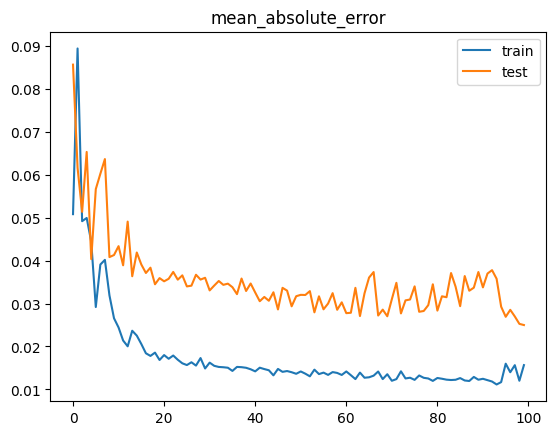

In [206]:
plt.title(main_obj_metric)
plt.plot(history.history[main_obj_metric], label='train')
plt.plot(history.history[f'val_{main_obj_metric}'], label='test')
plt.legend()
plt.show()

In [207]:
# import shap

# # we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(model, x_train)
# shap_values = explainer.shap_values(x_test)

# Step #5 Evaluate Model Performance

In [208]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
print(y_pred_scaled.shape)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
print(y_pred.shape)
print(y_test_unscaled.shape)

11/11 [==============================] - 1s 19ms/step
(342, 10)
(342, 10)
(342, 10)


In [209]:
RMSE = math.sqrt( mean_squared_error(y_test_unscaled, y_pred))
print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')


# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')




Root MEAN Square Error(RMSE): 8.26
Mean Absolute Error (MAE): 6.32
Median Absolute Error (MAE): 6.32
Mean Absolute Percentage Error (MAPE): 1.52 %
Median Absolute Percentage Error (MDAPE): 1.18 %


# Plot Multiple Forcast (Most Complex Step)

In [210]:
def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Close])\
    .rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = stockname + "_stock_price_quotes")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)



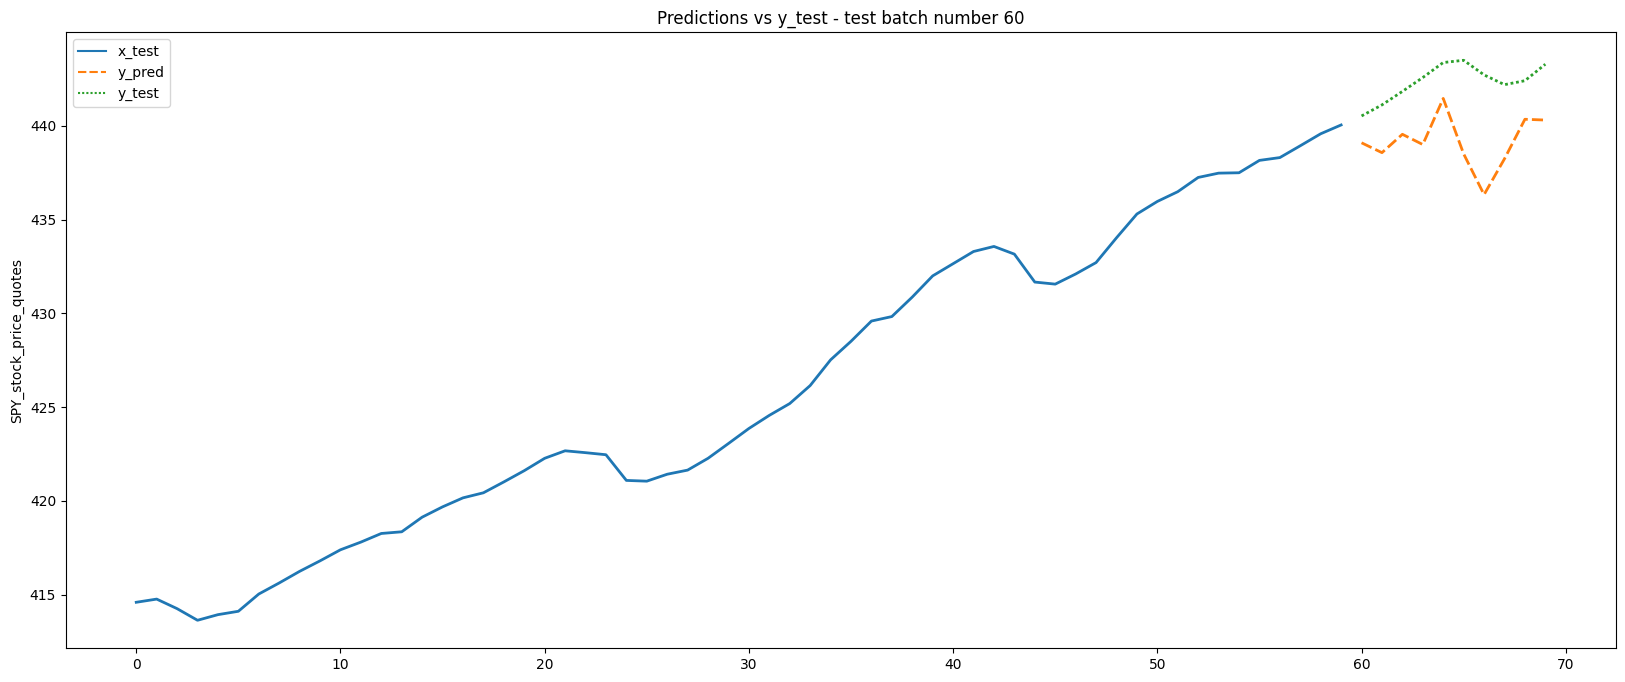

In [216]:
# Creates a linechart for a specific test batch_number and corresponding test predictions

x_test_unscaled_df, y_pred_df, y_test_unscaled_df = prepare_df(i, x_test, y_test, y_pred)
title = f"Predictions vs y_test - test batch number {input_sequence_length}"
plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title) 

# Step #6 Create a new Forecast

In [212]:
x_test_latest_batch = np_scaled[-(input_sequence_length+1):-1,:].reshape(1,input_sequence_length,len(feature_cols))
print(f"{x_test_latest_batch.shape} is the latest input batch from the test dataset, which is contains the price values for the last {input_sequence_length} trading days")

    
x_test_latest_batch

(1, 60, 1) is the latest input batch from the test dataset, which is contains the price values for the last 60 trading days


array([[[0.73236875],
        [0.73300127],
        [0.72600411],
        [0.71829538],
        [0.71034946],
        [0.70299652],
        [0.70374763],
        [0.69837128],
        [0.70058507],
        [0.70548703],
        [0.70762176],
        [0.70710784],
        [0.7131167 ],
        [0.72129981],
        [0.73232922],
        [0.73928684],
        [0.74351676],
        [0.75347881],
        [0.75960626],
        [0.76340133],
        [0.75956673],
        [0.75367647],
        [0.75264864],
        [0.75442758],
        [0.75735294],
        [0.75411132],
        [0.7662081 ],
        [0.77885832],
        [0.78676471],
        [0.79565939],
        [0.80075901],
        [0.80404016],
        [0.80803289],
        [0.81028621],
        [0.81589975],
        [0.82234345],
        [0.82752214],
        [0.82716635],
        [0.82637571],
        [0.83467742],
        [0.84123972],
        [0.84629981],
        [0.84515338],
        [0.8400933 ],
        [0.83546806],
        [0

In [213]:
y_pred_scaled = model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)
print(f"Predict on the inverse transformed batch {y_pred_unscaled.shape}")
print(y_pred_unscaled)

1/1 [==============================] - 0s 26ms/step
Predict on the inverse transformed batch (1, 10)
[[380.07736 378.6123  380.27692 380.44965 382.2753  380.62964 378.3971
  381.75745 385.16785 385.6605 ]]


In [214]:
print("Prepare the data and plot the input data and the predictions")
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
print(f"X-Test= {x_test_unscaled_df.shape}")
print(f"Y-Test= {y_test_unscaled_df.shape}")

# print(x_test_unscaled_df.tail(len(y_test_unscaled_df)))
# print(y_test_unscaled_df.tail(len(y_test_unscaled_df)))

Prepare the data and plot the input data and the predictions
X-Test= (60, 1)
Y-Test= (10, 1)


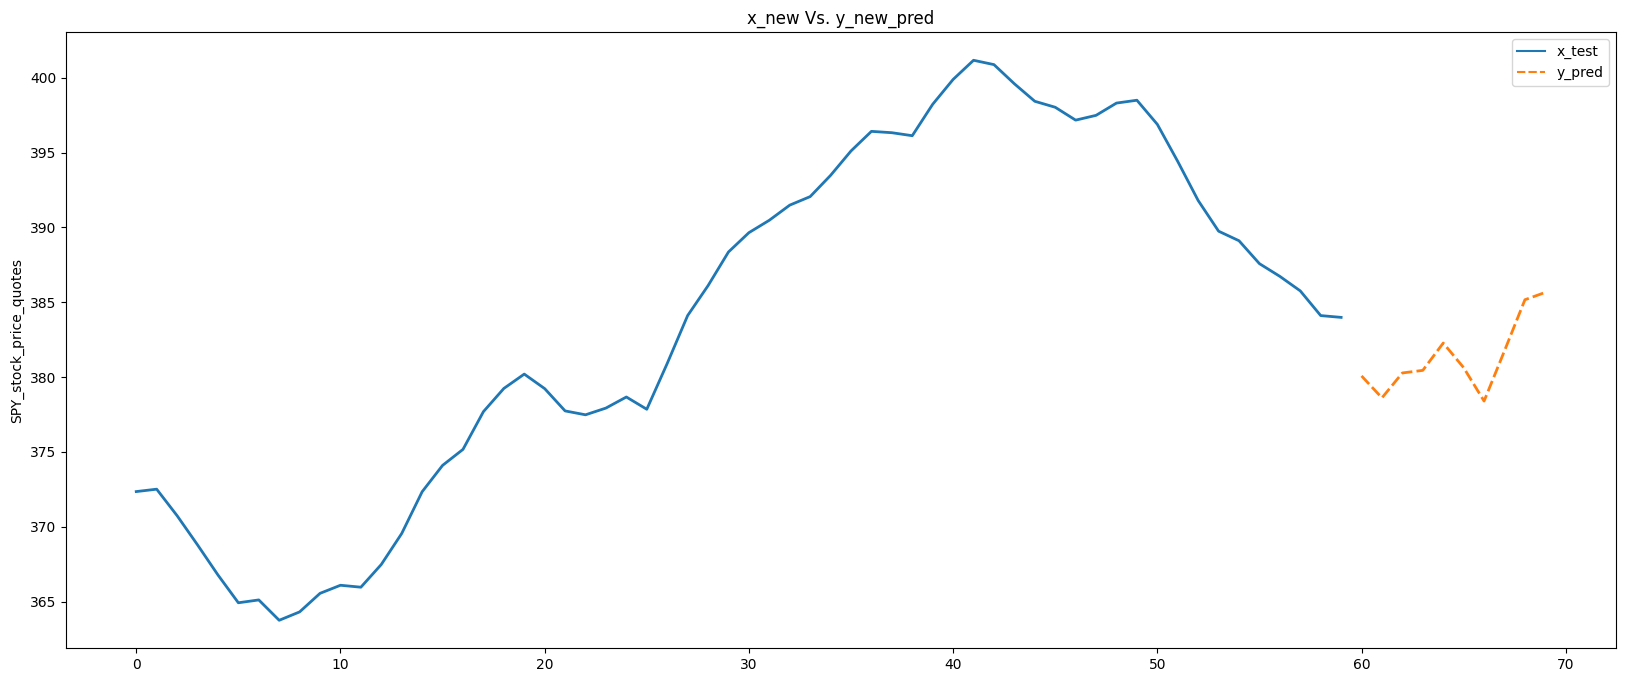

In [215]:
plot_multi_test_forecast(x_test_unscaled_df, '',y_test_unscaled_df, "x_new Vs. y_new_pred")